# ------------------------------ Big Mart Sales Prediction ---------------------------------

## Importing the required libraries

In [414]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
import sklearn.linear_model
import sklearn.ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## Importing the Big Mart datasets

In [415]:
train = pd.read_csv("BM_Train.csv") 
test = pd.read_csv("BM_Test.csv")

### Taking a look at the first 5 rows of the train dataset

In [416]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


### Checking the presence of non-null values

In [417]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  7060 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB


In [418]:
train.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


### Checking for duplicate values

In [419]:
idsUnique = len(set(train.Item_Identifier))
idsTotal = train.shape[0]
idsDupli = idsTotal - idsUnique
print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")

There are 6964 duplicate IDs for 8523 total entries


## Performing Exploratory Data Analysis (EDA)



### Firstly, performing univariate analysis

### Analyzing how the target variable i.e; Item_Outlet_Sales is distributed

Text(0.5, 1.0, 'Item_Outlet_Sales Distribution')

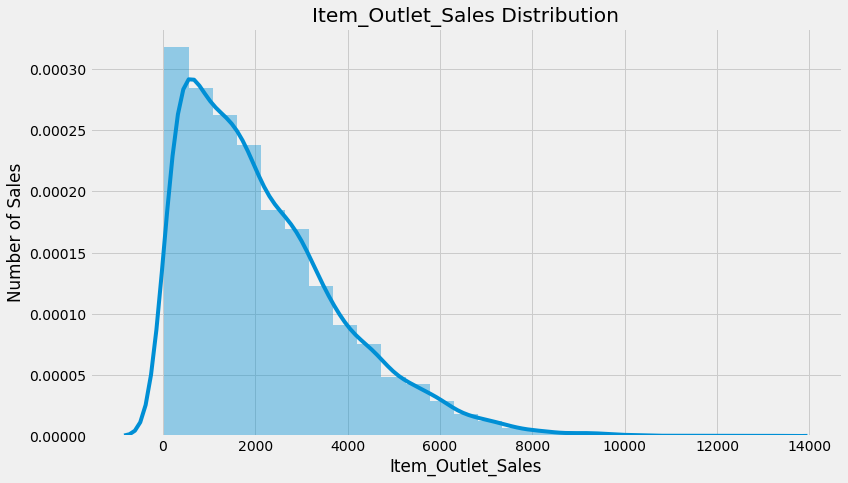

In [420]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,7))
sns.distplot(train.Item_Outlet_Sales, bins = 25)
plt.ticklabel_format(style='plain', axis='x', scilimits=(0,1))
plt.xlabel("Item_Outlet_Sales")
plt.ylabel("Number of Sales")
plt.title("Item_Outlet_Sales Distribution")

In [421]:
print ("Skew is:", train.Item_Outlet_Sales.skew())
print("Kurtosis: %f" % train.Item_Outlet_Sales.kurt())

Skew is: 1.1775306028542798
Kurtosis: 1.615877


### Aggregating all the numeric variables

In [422]:
numeric_features = train.select_dtypes(include=[np.number])
numeric_features.dtypes

Item_Weight                  float64
Item_Visibility              float64
Item_MRP                     float64
Outlet_Establishment_Year      int64
Item_Outlet_Sales            float64
dtype: object

In [423]:
numeric_features.corr()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Item_Weight,1.000000,-0.014048,0.027141,-0.011588,0.014123
Item_Visibility,-0.014048,1.000000,-0.001315,-0.074834,-0.128625
Item_MRP,0.027141,-0.001315,1.000000,0.005020,0.567574
Outlet_Establishment_Year,-0.011588,-0.074834,0.005020,1.000000,-0.049135
Item_Outlet_Sales,0.014123,-0.128625,0.567574,-0.049135,1.000000


In [424]:
corr = numeric_features.corr()
print (corr['Item_Outlet_Sales'].sort_values(ascending=False))

Item_Outlet_Sales            1.000000
Item_MRP                     0.567574
Item_Weight                  0.014123
Outlet_Establishment_Year   -0.049135
Item_Visibility             -0.128625
Name: Item_Outlet_Sales, dtype: float64


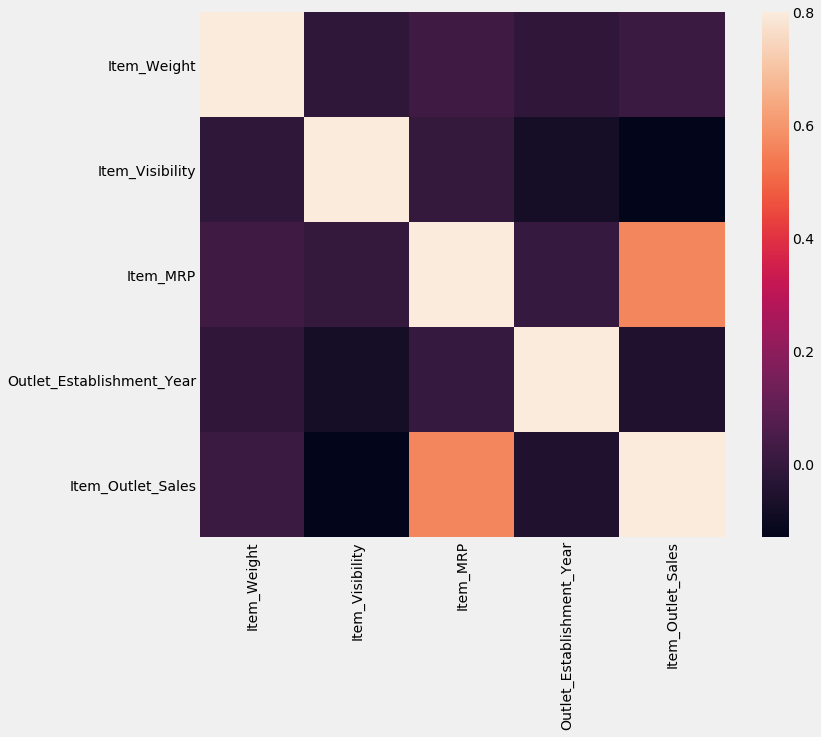

In [425]:
#correlation matrix
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr, vmax=.8, square=True);

## Performing EDA on the categorical variables

### Analyzing the distribution of Item_Fat _Content

In [426]:
train.Item_Fat_Content.value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

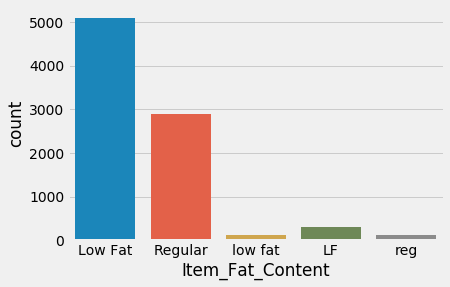

In [427]:
sns.countplot(train.Item_Fat_Content)

### Analyzing the distribution of Item_Type

In [428]:
train.Item_Type.value_counts()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

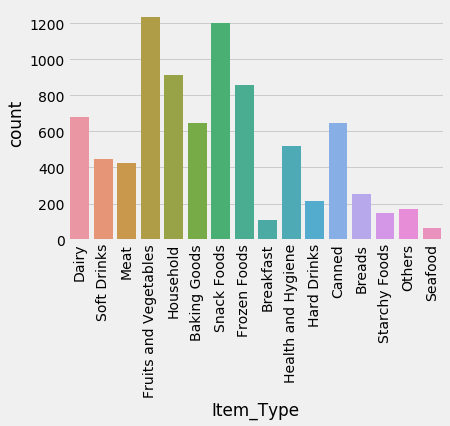

In [429]:
sns.countplot(train.Item_Type)
plt.xticks(rotation=90)

### Analyzing the distribution of Outlet_Size

In [430]:
train.Outlet_Size.value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

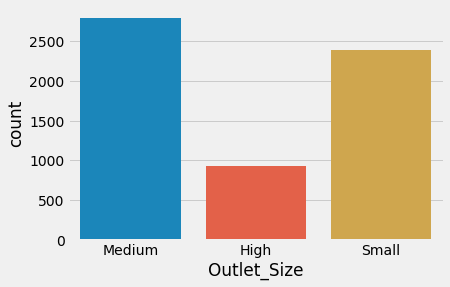

In [431]:
sns.countplot(train.Outlet_Size)

### Analyzing the distribution of Outlet_Location_type

In [432]:
train.Outlet_Location_Type.value_counts()

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

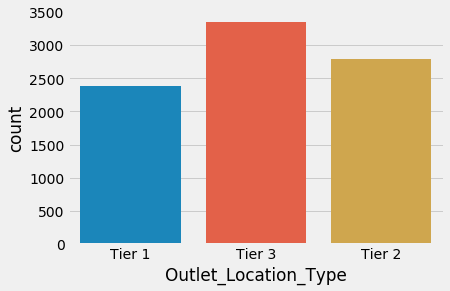

In [433]:
sns.countplot(train.Outlet_Location_Type)

### Analyzing the distribution of Outlet_Type

In [434]:
train.Outlet_Type.value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

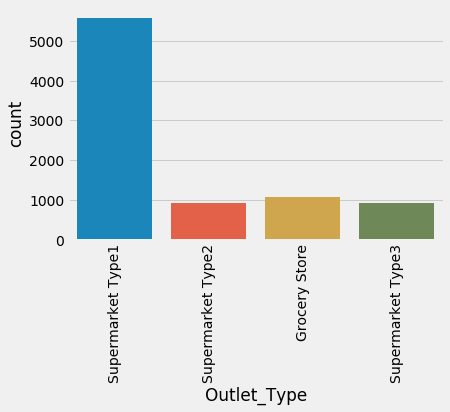

In [435]:
sns.countplot(train.Outlet_Type)
plt.xticks(rotation=90)

## Now performing Bivariate analysis of the variables

### On Numerical Variables

### Item_Weight and Item_Outlet_Sales Analysis

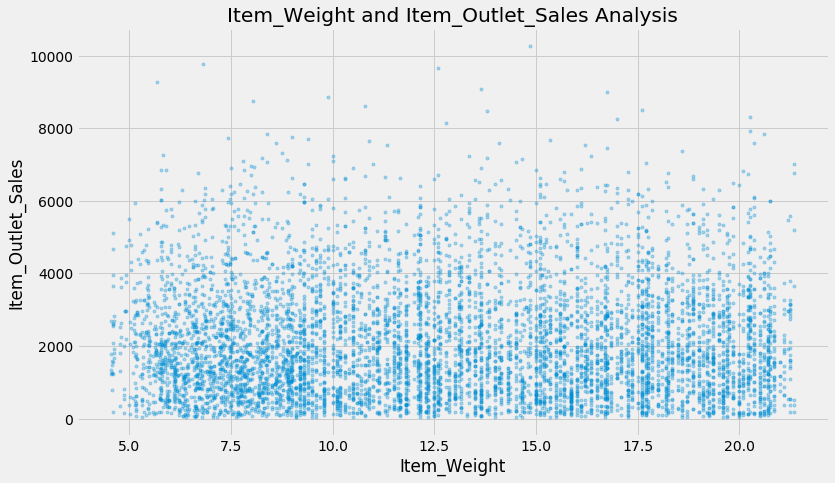

In [436]:
plt.figure(figsize=(12,7))
plt.xlabel("Item_Weight")
plt.ylabel("Item_Outlet_Sales")
plt.title("Item_Weight and Item_Outlet_Sales Analysis")
plt.plot(train.Item_Weight, train["Item_Outlet_Sales"],'.', alpha = 0.3)

### Item_Visibility and Item_Outlet_Sales Analysis

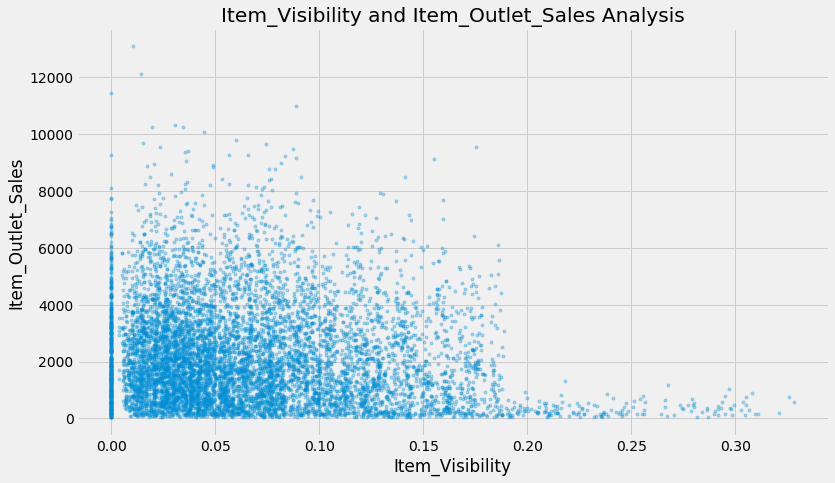

In [437]:
plt.figure(figsize=(12,7))
plt.xlabel("Item_Visibility")
plt.ylabel("Item_Outlet_Sales")
plt.title("Item_Visibility and Item_Outlet_Sales Analysis")
plt.plot(train.Item_Visibility, train["Item_Outlet_Sales"],'.', alpha = 0.3)

### Item_MRP and Item_Outlet_Sales Analysis

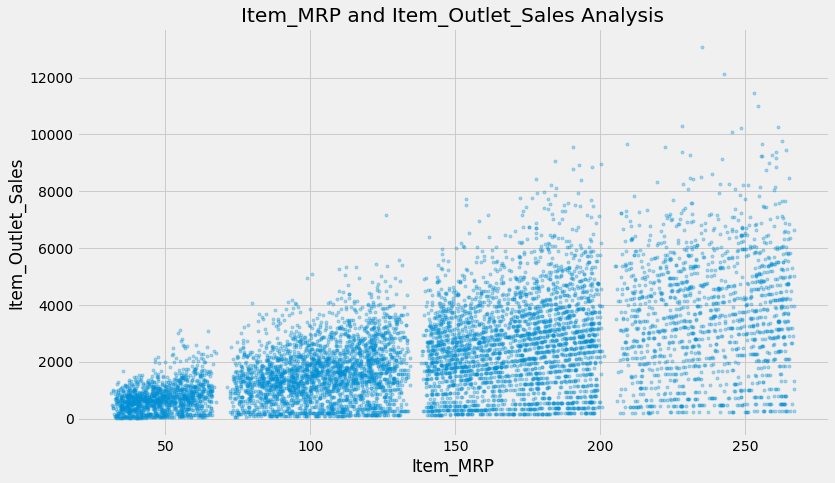

In [438]:
plt.figure(figsize=(12,7))
plt.xlabel("Item_MRP")
plt.ylabel("Item_Outlet_Sales")
plt.title("Item_MRP and Item_Outlet_Sales Analysis")
plt.plot(train.Item_MRP, train["Item_Outlet_Sales"],'.', alpha = 0.3)

### Outlet_Establishment_Year and Item_Outlet_Sales Analysis

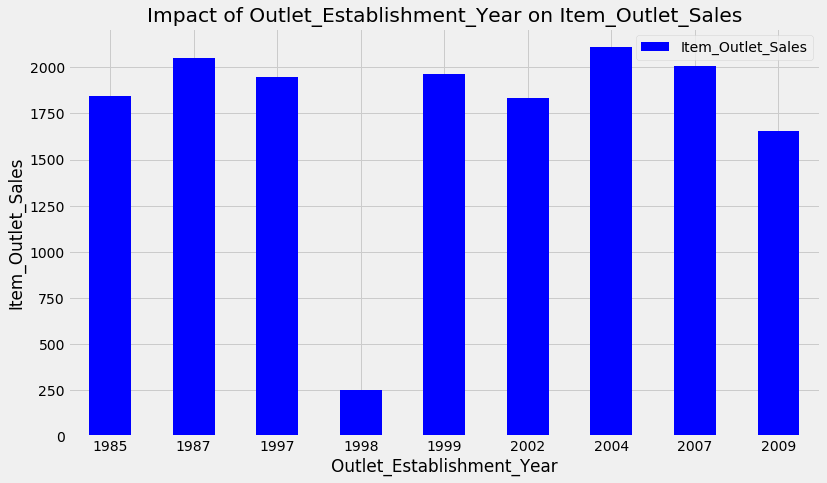

In [439]:
Outlet_Establishment_Year_pivot = \
train.pivot_table(index='Outlet_Establishment_Year', values="Item_Outlet_Sales", aggfunc=np.median)

Outlet_Establishment_Year_pivot.plot(kind='bar', color='blue',figsize=(12,7))
plt.xlabel("Outlet_Establishment_Year")
plt.ylabel("Item_Outlet_Sales")
plt.title("Impact of Outlet_Establishment_Year on Item_Outlet_Sales")
plt.xticks(rotation=0)
plt.show()

## Performing bivariate analysis on categorical variables

In [440]:
numeric_features = train.select_dtypes(include=[np.object])
numeric_features.dtypes

Item_Identifier         object
Item_Fat_Content        object
Item_Type               object
Outlet_Identifier       object
Outlet_Size             object
Outlet_Location_Type    object
Outlet_Type             object
dtype: object

### Analyzing the impact of Item_Identifier on Item_Outlet_Sales

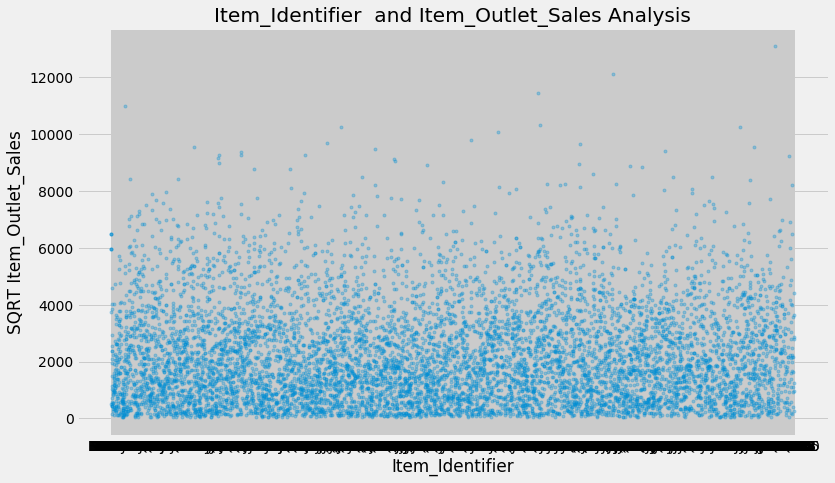

In [441]:
plt.figure(figsize=(12,7))
plt.xlabel("Item_Identifier")
plt.ylabel("SQRT Item_Outlet_Sales")
plt.title("Item_Identifier  and Item_Outlet_Sales Analysis")
plt.plot(train.Item_Identifier , train["Item_Outlet_Sales"],'.', alpha = 0.3)

### Analyzing the impact of Item_Fat_Content on Item_Outlet_Sales

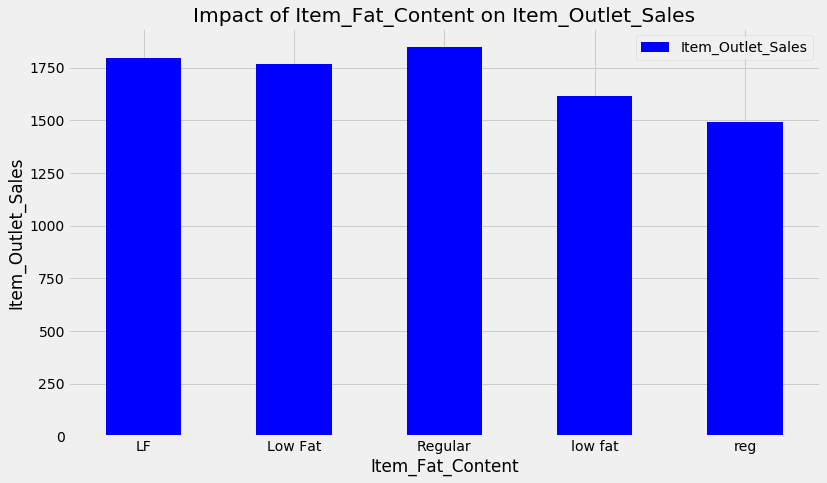

In [442]:
Item_Fat_Content_pivot = \
train.pivot_table(index='Item_Fat_Content', values="Item_Outlet_Sales", aggfunc=np.median)

Item_Fat_Content_pivot.plot(kind='bar', color='blue',figsize=(12,7))
plt.xlabel("Item_Fat_Content")
plt.ylabel("Item_Outlet_Sales")
plt.title("Impact of Item_Fat_Content on Item_Outlet_Sales")
plt.xticks(rotation=0)
plt.show()

### Analyzing the impact of Outlet_Identifier on Item_Outlet_Sales

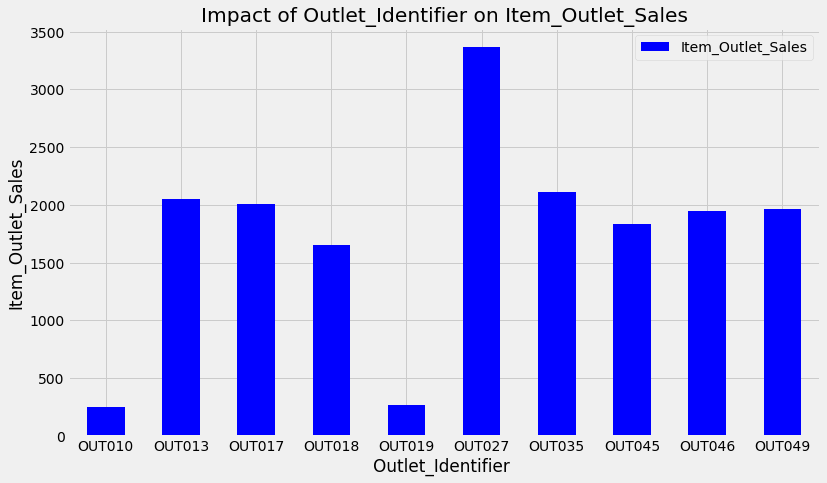

In [443]:
Outlet_Identifier_pivot = \
train.pivot_table(index='Outlet_Identifier', values="Item_Outlet_Sales", aggfunc=np.median)

Outlet_Identifier_pivot.plot(kind='bar', color='blue',figsize=(12,7))
plt.xlabel("Outlet_Identifier ")
plt.ylabel("Item_Outlet_Sales")
plt.title("Impact of Outlet_Identifier on Item_Outlet_Sales")
plt.xticks(rotation=0)
plt.show()

In [444]:
train.pivot_table(values='Outlet_Type', columns='Outlet_Identifier',aggfunc=lambda x:x.mode())

Outlet_Identifier,OUT010,OUT013,OUT017,OUT018,OUT019,OUT027,OUT035,OUT045,OUT046,OUT049
Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type1,Supermarket Type2,Grocery Store,Supermarket Type3,Supermarket Type1,Supermarket Type1,Supermarket Type1,Supermarket Type1


In [445]:
train.pivot_table(values='Outlet_Type', columns='Outlet_Size',aggfunc=lambda x:x.mode())

Outlet_Size,High,Medium,Small
Outlet_Type,Supermarket Type1,Supermarket Type3,Supermarket Type1


### Analyzing the impact of Outlet_Size on Item_Outlet_Sales

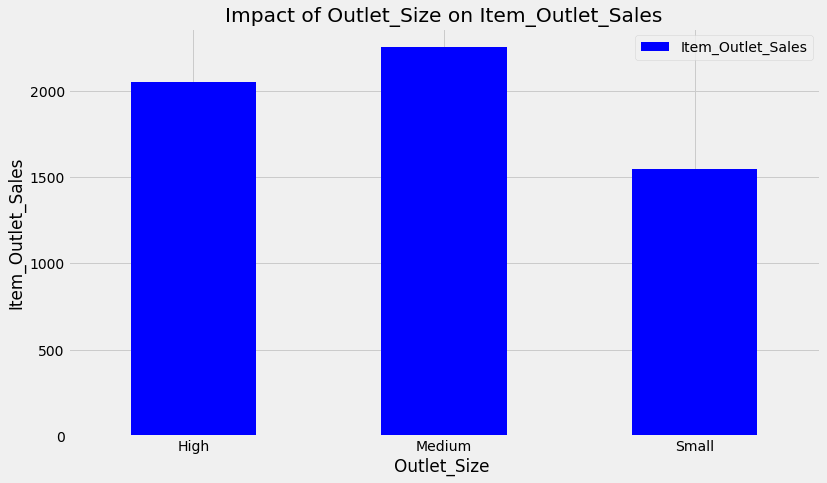

In [446]:
Outlet_Size_pivot = \
train.pivot_table(index='Outlet_Size', values="Item_Outlet_Sales", aggfunc=np.median)

Outlet_Size_pivot.plot(kind='bar', color='blue',figsize=(12,7))
plt.xlabel("Outlet_Size ")
plt.ylabel("Item_Outlet_Sales")
plt.title("Impact of Outlet_Size on Item_Outlet_Sales")
plt.xticks(rotation=0)
plt.show()

### Analyzing the impact of Outlet_Location_Type on Item_Outlet_Sales

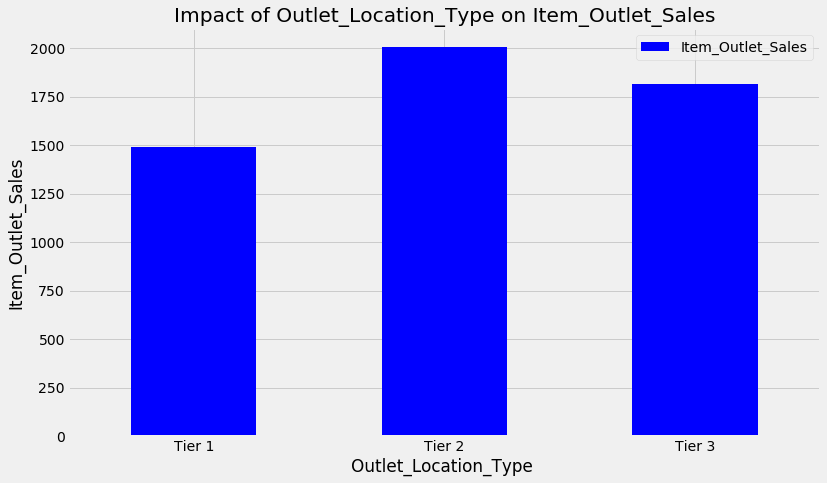

In [447]:
Outlet_Location_Type_pivot = \
train.pivot_table(index='Outlet_Location_Type', values="Item_Outlet_Sales", aggfunc=np.median)

Outlet_Location_Type_pivot.plot(kind='bar', color='blue',figsize=(12,7))
plt.xlabel("Outlet_Location_Type ")
plt.ylabel("Item_Outlet_Sales")
plt.title("Impact of Outlet_Location_Type on Item_Outlet_Sales")
plt.xticks(rotation=0)
plt.show()

In [448]:
train.pivot_table(values='Outlet_Location_Type', columns='Outlet_Type',aggfunc=lambda x:x.mode())

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Location_Type,Tier 3,Tier 2,Tier 3,Tier 3


### Analyzing the impact of Outlet_Type on Item_Outlet_Sales

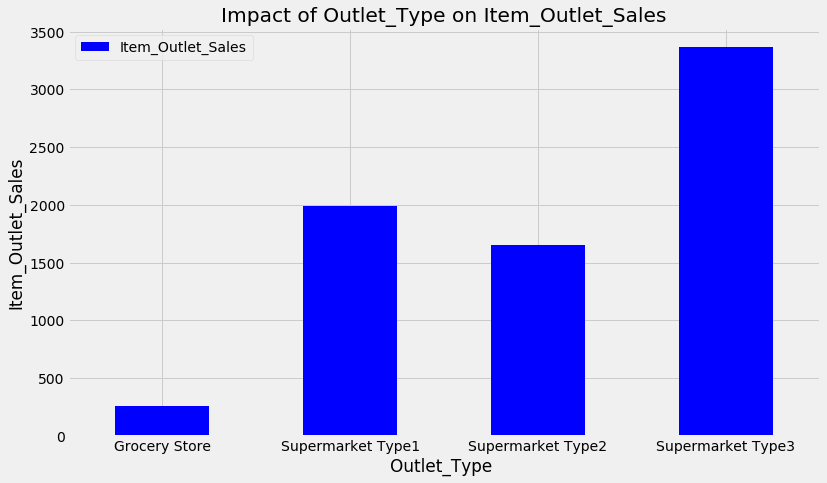

In [449]:
Outlet_Type_pivot = \
train.pivot_table(index='Outlet_Type', values="Item_Outlet_Sales", aggfunc=np.median)

Outlet_Type_pivot.plot(kind='bar', color='blue',figsize=(12,7))
plt.xlabel("Outlet_Type ")
plt.ylabel("Item_Outlet_Sales")
plt.title("Impact of Outlet_Type on Item_Outlet_Sales")
plt.xticks(rotation=0)
plt.show()

### Analyzing the impact of Item_Type on Item_Outlet_Sales

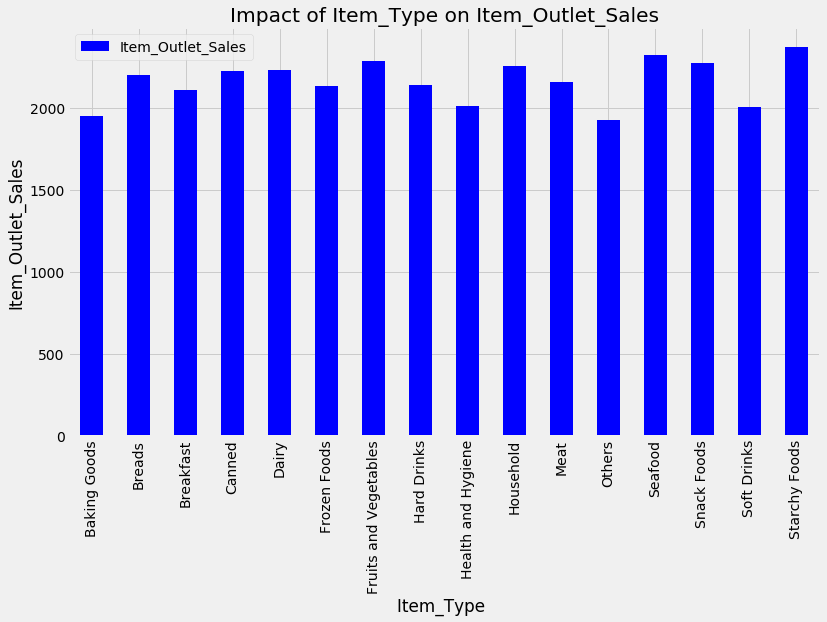

In [450]:
pivoTable = \
train.pivot_table(index='Item_Type', values="Item_Outlet_Sales", aggfunc=np.mean)

pivoTable.plot(kind='bar', color='blue',figsize=(12,7))
plt.xlabel("Item_Type ")
plt.ylabel("Item_Outlet_Sales")
plt.title("Impact of Item_Type on Item_Outlet_Sales")
plt.xticks(rotation=90)
plt.show()

## I want to combine both train and test data sets into one, perform feature engineering and then divide them later again. This saves the trouble of performing the same steps twice on test and train datasets. I will combine them into a dataframe ‘data’ with a ‘source’ column specifying where each observation belongs.

In [451]:
train['source'] = 'train'
test['source'] = 'test'

In [452]:
df = pd.concat([train, test], ignore_index=True)
print (train.shape, test.shape, df.shape)

(8523, 13) (5681, 12) (14204, 13)


## Checking columns with missing values

In [453]:
df.isnull().sum()

Item_Fat_Content                0
Item_Identifier                 0
Item_MRP                        0
Item_Outlet_Sales            5681
Item_Type                       0
Item_Visibility                 0
Item_Weight                  2439
Outlet_Establishment_Year       0
Outlet_Identifier               0
Outlet_Location_Type            0
Outlet_Size                  4016
Outlet_Type                     0
source                          0
dtype: int64

In [454]:
train.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
source                          0
dtype: int64

In [456]:
test.isnull().sum()

Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
source                          0
dtype: int64

In [457]:
df.describe()

,Item_MRP,Item_Outlet_Sales,Item_Visibility,Item_Weight,Outlet_Establishment_Year
count,14204.000000,8523.000000,14204.000000,11765.000000,14204.000000
mean,141.004977,2181.288914,0.065953,12.792854,1997.830681
std,62.086938,1706.499616,0.051459,4.652502,8.371664
min,31.290000,33.290000,0.000000,4.555000,1985.000000
25%,94.012000,834.247400,0.027036,8.710000,1987.000000
50%,142.247000,1794.331000,0.054021,12.600000,1999.000000
75%,185.855600,3101.296400,0.094037,16.750000,2004.000000
max,266.888400,13086.964800,0.328391,21.350000,2009.000000


## Item_Visibility cannot be 0. Hence fixing the outliers

In [458]:
df[df.Item_Visibility == 0].shape

(879, 13)

In [459]:
df['Item_Visibility'] = df.Item_Visibility.apply(lambda x: x if x>0 else pd.np.nan)

In [460]:
df.Item_Visibility = df.groupby('Item_Identifier')['Item_Visibility'].apply(lambda x: x.fillna(x.mean()))

In [461]:
df[df.Item_Visibility == 0].shape

(0, 13)

## Checking for unique values in each column

In [462]:
df.apply(lambda x: len(x.unique()))

Item_Fat_Content                 5
Item_Identifier               1559
Item_MRP                      8052
Item_Outlet_Sales             3494
Item_Type                       16
Item_Visibility              13688
Item_Weight                    416
Outlet_Establishment_Year        9
Outlet_Identifier               10
Outlet_Location_Type             3
Outlet_Size                      4
Outlet_Type                      4
source                           2
dtype: int64

In [463]:
df.Item_Type.value_counts()

Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

In [464]:
df.Outlet_Type.value_counts()

Supermarket Type1    9294
Grocery Store        1805
Supermarket Type3    1559
Supermarket Type2    1546
Name: Outlet_Type, dtype: int64

In [465]:
df.Outlet_Establishment_Year .value_counts()

1985    2439
1987    1553
1999    1550
1997    1550
2004    1550
2002    1548
2009    1546
2007    1543
1998     925
Name: Outlet_Establishment_Year, dtype: int64

In [466]:
df.Item_Fat_Content .value_counts()

Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

## We need to replace LF by Low Fat, low fat by Low Fat & reg by Regular

In [467]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF':'Low Fat','reg':'Regular','low fat':'Low Fat'})

In [468]:
df.Item_Fat_Content.value_counts()

Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64

In [469]:
df.Outlet_Size .value_counts()

Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64

In [470]:
df.Outlet_Location_Type .value_counts()

Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64

# Data Cleaning

## Fill the missing value for Item_Weight with the average weight of the particular item (Using Item_Identifier).

In [471]:
df.Item_Weight = df.groupby('Item_Identifier')['Item_Weight'].apply(lambda x: x.fillna(x.mean()))

In [472]:
df.Item_Weight.isnull().sum()

0

In [473]:
df.isnull().sum()

Item_Fat_Content                0
Item_Identifier                 0
Item_MRP                        0
Item_Outlet_Sales            5681
Item_Type                       0
Item_Visibility                 0
Item_Weight                     0
Outlet_Establishment_Year       0
Outlet_Identifier               0
Outlet_Location_Type            0
Outlet_Size                  4016
Outlet_Type                     0
source                          0
dtype: int64

## Fill the missing value for Outlet_Size with the mode of Outlet_Size for the particular Outlet_Type

In [474]:
df.Outlet_Size.value_counts()

Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64

In [475]:
df.Outlet_Type.value_counts()

Supermarket Type1    9294
Grocery Store        1805
Supermarket Type3    1559
Supermarket Type2    1546
Name: Outlet_Type, dtype: int64

In [476]:
df.groupby('Outlet_Type').Outlet_Size.value_counts()

Outlet_Type        Outlet_Size
Grocery Store      Small           880
Supermarket Type1  Small          3100
                   High           1553
                   Medium         1550
Supermarket Type2  Medium         1546
Supermarket Type3  Medium         1559
Name: Outlet_Size, dtype: int64

In [477]:
outlet_size_mode = df.pivot_table(values='Outlet_Size', columns='Outlet_Type',aggfunc=(lambda x:mode(x).mode[0]) )

miss_bool = df['Outlet_Size'].isnull()

df.loc[miss_bool,'Outlet_Size'] = df.loc[miss_bool,'Outlet_Type'].apply(lambda x: outlet_size_mode[x])

In [478]:
df.Outlet_Size.isnull().sum()

0

In [479]:
df.Outlet_Type.value_counts()

Supermarket Type1    9294
Grocery Store        1805
Supermarket Type3    1559
Supermarket Type2    1546
Name: Outlet_Type, dtype: int64

In [480]:
df.isnull().sum()

Item_Fat_Content                0
Item_Identifier                 0
Item_MRP                        0
Item_Outlet_Sales            5681
Item_Type                       0
Item_Visibility                 0
Item_Weight                     0
Outlet_Establishment_Year       0
Outlet_Identifier               0
Outlet_Location_Type            0
Outlet_Size                     0
Outlet_Type                     0
source                          0
dtype: int64

In [481]:
df.head(2)

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,source
0,Low Fat,FDA15,249.8092,3735.1380,Dairy,0.016047,9.30,1999,OUT049,Tier 1,Medium,Supermarket Type1,train
1,Regular,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.92,2009,OUT018,Tier 3,Medium,Supermarket Type2,train


# Feature Engineering

In [483]:
df.Item_Identifier.unique()

array(['FDA15', 'DRC01', 'FDN15', ..., 'NCF55', 'NCW30', 'NCW05'],
      dtype=object)

In [484]:
df.Item_Type.unique()

array(['Dairy', 'Soft Drinks', 'Meat', 'Fruits and Vegetables',
       'Household', 'Baking Goods', 'Snack Foods', 'Frozen Foods',
       'Breakfast', 'Health and Hygiene', 'Hard Drinks', 'Canned',
       'Breads', 'Starchy Foods', 'Others', 'Seafood'], dtype=object)

In [485]:
unique_keys = df['Item_Identifier'].apply(lambda x: x[0:2])

In [486]:
df['Item_Type_Category'] = unique_keys.map({'FD':'Food','NC':'Non-Consumable','DR':'Drinks'})

In [487]:
df.head(2)

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,source,Item_Type_Category
0,Low Fat,FDA15,249.8092,3735.1380,Dairy,0.016047,9.30,1999,OUT049,Tier 1,Medium,Supermarket Type1,train,Food
1,Regular,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.92,2009,OUT018,Tier 3,Medium,Supermarket Type2,train,Drinks


In [488]:
df['Item_Type_Category'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Category, dtype: int64

In [489]:
df['Years_of_Operation'] = 2013 - df['Outlet_Establishment_Year']

In [490]:
df.head(2)

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,source,Item_Type_Category,Years_of_Operation
0,Low Fat,FDA15,249.8092,3735.1380,Dairy,0.016047,9.30,1999,OUT049,Tier 1,Medium,Supermarket Type1,train,Food,14
1,Regular,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.92,2009,OUT018,Tier 3,Medium,Supermarket Type2,train,Drinks,4


In [491]:
df.Years_of_Operation.value_counts()

28    2439
26    1553
14    1550
9     1550
16    1550
11    1548
4     1546
6     1543
15     925
Name: Years_of_Operation, dtype: int64

In [492]:
df.Years_of_Operation.describe()

count    14204.000000
mean        15.169319
std          8.371664
min          4.000000
25%          9.000000
50%         14.000000
75%         26.000000
max         28.000000
Name: Years_of_Operation, dtype: float64

# We need to clean the data further

In [493]:
df.Item_Fat_Content.value_counts()

Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64

In [494]:
df.Item_Type_Category.value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Category, dtype: int64

In [495]:
df.loc[df['Item_Type_Category']=="Non-Consumable",'Item_Fat_Content'] = "None"

In [496]:
df.Item_Fat_Content.value_counts()

Low Fat    6499
Regular    5019
None       2686
Name: Item_Fat_Content, dtype: int64

In [497]:
df.head()

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,source,Item_Type_Category,Years_of_Operation
0,Low Fat,FDA15,249.8092,3735.1380,Dairy,0.016047,9.30,1999,OUT049,Tier 1,Medium,Supermarket Type1,train,Food,14
1,Regular,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.92,2009,OUT018,Tier 3,Medium,Supermarket Type2,train,Drinks,4
2,Low Fat,FDN15,141.6180,2097.2700,Meat,0.016760,17.50,1999,OUT049,Tier 1,Medium,Supermarket Type1,train,Food,14
3,Regular,FDX07,182.0950,732.3800,Fruits and Vegetables,0.022930,19.20,1998,OUT010,Tier 3,Small,Grocery Store,train,Food,15
4,None,NCD19,53.8614,994.7052,Household,0.014670,8.93,1987,OUT013,Tier 3,High,Supermarket Type1,train,Non-Consumable,26


In [498]:
df.groupby('Item_Fat_Content').Item_Outlet_Sales.mean()

Item_Fat_Content
Low Fat    2163.829268
None       2142.721364
Regular    2224.561170
Name: Item_Outlet_Sales, dtype: float64

In [499]:
df.groupby('Item_Fat_Content').Item_Outlet_Sales.describe()

,count,mean,std,min,25%,50%,75%,max
Item_Fat_Content,,,,,,,,
Low Fat,3918.0,2163.829268,1726.302029,33.2900,830.9184,1733.0774,3060.84905,11445.1020
None,1599.0,2142.721364,1626.907672,33.2900,815.6050,1874.8928,3016.73980,13086.9648
Regular,3006.0,2224.561170,1721.480865,33.9558,857.5504,1844.5989,3198.66965,12117.5600


In [500]:
df.groupby('Outlet_Establishment_Year').Item_Outlet_Sales.describe()

,count,mean,std,min,25%,50%,75%,max
Outlet_Establishment_Year,,,,,,,,
1985,1463.0,2483.677474,2347.516621,33.9558,399.48000,1845.5976,3968.16800,13086.9648
1987,932.0,2298.995256,1533.531664,73.2380,1072.60380,2050.6640,3166.37835,10256.6490
1997,930.0,2277.844267,1488.405631,101.8674,1137.18640,1945.8005,3095.63710,9779.9362
1998,555.0,339.351662,271.014855,33.2900,154.13270,250.3408,455.40720,1775.6886
1999,930.0,2348.354635,1513.289464,111.8544,1182.79370,1966.1074,3281.72820,7646.0472
2002,929.0,2192.384798,1462.399658,99.8700,1068.60900,1834.9448,2929.52000,8994.9580
2004,930.0,2438.841866,1538.512533,113.8518,1238.88735,2109.2544,3310.35760,8479.6288
2007,926.0,2340.675263,1550.778025,143.8128,1195.94325,2005.0567,3096.46935,9664.7528
2009,928.0,1995.498739,1375.932889,69.2432,981.55565,1655.1788,2702.64865,6768.5228


In [501]:
df.groupby('Outlet_Type').Item_Outlet_Sales.describe()

,count,mean,std,min,25%,50%,75%,max
Outlet_Type,,,,,,,,
Grocery Store,1083.0,339.828500,260.851582,33.2900,153.79980,256.9988,458.73620,1775.6886
Supermarket Type1,5577.0,2316.181148,1515.965558,73.2380,1151.16820,1990.7420,3135.91800,10256.6490
Supermarket Type2,928.0,1995.498739,1375.932889,69.2432,981.55565,1655.1788,2702.64865,6768.5228
Supermarket Type3,935.0,3694.038558,2127.760054,241.6854,2044.33890,3364.9532,4975.52340,13086.9648


In [502]:
df.groupby('Outlet_Type').Item_Fat_Content.value_counts()

Outlet_Type        Item_Fat_Content
Grocery Store      Low Fat              820
                   Regular              640
                   None                 345
Supermarket Type1  Low Fat             4257
                   Regular             3281
                   None                1756
Supermarket Type2  Low Fat              709
                   Regular              547
                   None                 290
Supermarket Type3  Low Fat              713
                   Regular              551
                   None                 295
Name: Item_Fat_Content, dtype: int64

In [503]:
df.groupby('Outlet_Type').Outlet_Location_Type.describe()

,count,unique,top,freq
Outlet_Type,,,,
Grocery Store,1805,2,Tier 3,925
Supermarket Type1,9294,3,Tier 2,4641
Supermarket Type2,1546,1,Tier 3,1546
Supermarket Type3,1559,1,Tier 3,1559


In [504]:
df.groupby('Outlet_Type').Item_Fat_Content.describe()

,count,unique,top,freq
Outlet_Type,,,,
Grocery Store,1805,3,Low Fat,820
Supermarket Type1,9294,3,Low Fat,4257
Supermarket Type2,1546,3,Low Fat,709
Supermarket Type3,1559,3,Low Fat,713


In [505]:
df.head()

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,source,Item_Type_Category,Years_of_Operation
0,Low Fat,FDA15,249.8092,3735.1380,Dairy,0.016047,9.30,1999,OUT049,Tier 1,Medium,Supermarket Type1,train,Food,14
1,Regular,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.92,2009,OUT018,Tier 3,Medium,Supermarket Type2,train,Drinks,4
2,Low Fat,FDN15,141.6180,2097.2700,Meat,0.016760,17.50,1999,OUT049,Tier 1,Medium,Supermarket Type1,train,Food,14
3,Regular,FDX07,182.0950,732.3800,Fruits and Vegetables,0.022930,19.20,1998,OUT010,Tier 3,Small,Grocery Store,train,Food,15
4,None,NCD19,53.8614,994.7052,Household,0.014670,8.93,1987,OUT013,Tier 3,High,Supermarket Type1,train,Non-Consumable,26


In [506]:
df.isnull().sum()

Item_Fat_Content                0
Item_Identifier                 0
Item_MRP                        0
Item_Outlet_Sales            5681
Item_Type                       0
Item_Visibility                 0
Item_Weight                     0
Outlet_Establishment_Year       0
Outlet_Identifier               0
Outlet_Location_Type            0
Outlet_Size                     0
Outlet_Type                     0
source                          0
Item_Type_Category              0
Years_of_Operation              0
dtype: int64

## Now we need to convert all categorical varibles into numerical variables

In [507]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#New variable for outlet
df['Outlet'] = le.fit_transform(df['Outlet_Identifier'])
var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type_Category','Outlet_Type','Outlet']
le = LabelEncoder()
for i in var_mod:
    df[i] = le.fit_transform(df[i])

In [508]:
#One Hot Coding:
data = pd.get_dummies(df, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type_Category','Outlet_Type','Outlet'])

In [509]:
data.dtypes

Item_Identifier               object
Item_MRP                     float64
Item_Outlet_Sales            float64
Item_Type                     object
Item_Visibility              float64
Item_Weight                  float64
Outlet_Establishment_Year      int64
Outlet_Identifier             object
source                        object
Years_of_Operation             int64
Item_Fat_Content_0             uint8
Item_Fat_Content_1             uint8
Item_Fat_Content_2             uint8
Outlet_Location_Type_0         uint8
Outlet_Location_Type_1         uint8
Outlet_Location_Type_2         uint8
Outlet_Size_0                  uint8
Outlet_Size_1                  uint8
Outlet_Size_2                  uint8
Item_Type_Category_0           uint8
Item_Type_Category_1           uint8
Item_Type_Category_2           uint8
Outlet_Type_0                  uint8
Outlet_Type_1                  uint8
Outlet_Type_2                  uint8
Outlet_Type_3                  uint8
Outlet_0                       uint8
O

In [510]:
data[['Item_Fat_Content_0','Item_Fat_Content_1','Item_Fat_Content_2']].head()

,Item_Fat_Content_0,Item_Fat_Content_1,Item_Fat_Content_2
0,1,0,0
1,0,0,1
2,1,0,0
3,0,0,1
4,0,1,0


## Now we need to split the dataframe back into train and test datasets.

In [511]:
train = data.loc[data['source']=="train"]
test = data.loc[data['source']=="test"]

In [512]:
train.shape

(8523, 36)

In [513]:
test.shape

(5681, 36)

In [514]:
train.drop(['source', 'Outlet_Establishment_Year','Item_Type'],axis=1,inplace=True)
test.drop(['Item_Outlet_Sales','source', 'Outlet_Establishment_Year','Item_Type'],axis=1,inplace=True)

In [515]:
train.shape

(8523, 33)

In [516]:
test.shape

(5681, 32)

# Model Building

## Linear Regression

In [517]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

In [518]:
X= train.drop(['Item_Outlet_Sales', 'Item_Identifier', 'Outlet_Identifier'],axis=1)

In [519]:
X.head()

,Item_MRP,Item_Visibility,Item_Weight,Years_of_Operation,Item_Fat_Content_0,Item_Fat_Content_1,Item_Fat_Content_2,Outlet_Location_Type_0,Outlet_Location_Type_1,Outlet_Location_Type_2,...,Outlet_0,Outlet_1,Outlet_2,Outlet_3,Outlet_4,Outlet_5,Outlet_6,Outlet_7,Outlet_8,Outlet_9
0,249.8092,0.016047,9.30,14,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,48.2692,0.019278,5.92,4,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,141.6180,0.016760,17.50,14,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,182.0950,0.022930,19.20,15,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0
4,53.8614,0.014670,8.93,26,0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0


In [520]:
y= train.Item_Outlet_Sales

In [522]:
print (X.shape)
print (y.shape)

(8523, 30)
(8523,)


In [523]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [529]:
target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier','Outlet_Identifier']
from sklearn import metrics
from sklearn.model_selection import cross_val_score
def modelfit(alg, dtrain, dtest, predictors, target, IDcol, filename):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])

    #Perform cross-validation:
    cv_score = cross_val_score(alg, dtrain[predictors], dtrain[target], cv=20)
    cv_score = np.sqrt(np.abs(cv_score))
    
    #Print model report:
    print ("\nModel Report")
    print ("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions)))
    print ("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    #Predict on testing data:
    dtest[target] = alg.predict(dtest[predictors])


Model Report
RMSE : 1128
CV Score : Mean - 0.7476 | Std - 0.01941 | Min - 0.6984 | Max - 0.7846


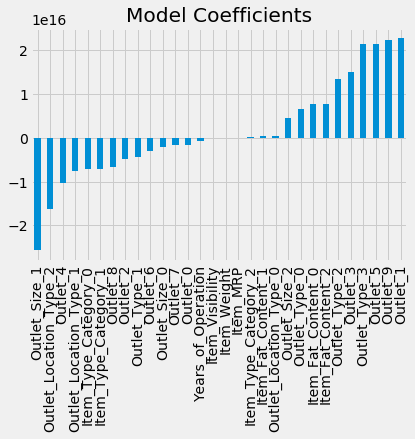

In [530]:
predictors = [x for x in train.columns if x not in [target]+IDcol]
# Print prediction
alg1 = LinearRegression(normalize=True)
modelfit(alg1, train, test, predictors, target, IDcol, 'alg1.csv')
coef1 = pd.Series(alg1.coef_, predictors).sort_values()
coef1.plot(kind='bar', title='Model Coefficients')

## Random Forest


Model Report
RMSE : 1073
CV Score : Mean - 0.77 | Std - 0.02191 | Min - 0.7217 | Max - 0.8047


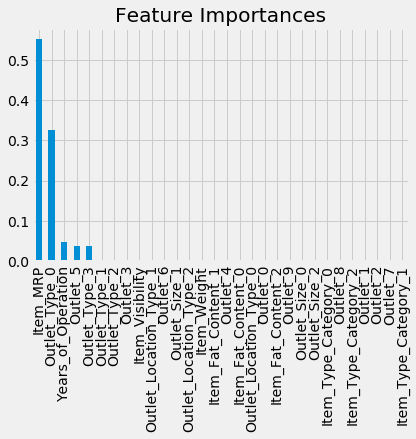

In [531]:
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg5 = RandomForestRegressor(n_estimators=200,max_depth=5, min_samples_leaf=100,n_jobs=4)
modelfit(alg5, train, test, predictors, target, IDcol, 'alg5.csv')
coef5 = pd.Series(alg5.feature_importances_, predictors).sort_values(ascending=False)
coef5.plot(kind='bar', title='Feature Importances')

## Decision Tree


Model Report
RMSE : 1060
CV Score : Mean - 0.7656 | Std - 0.02488 | Min - 0.7049 | Max - 0.8176


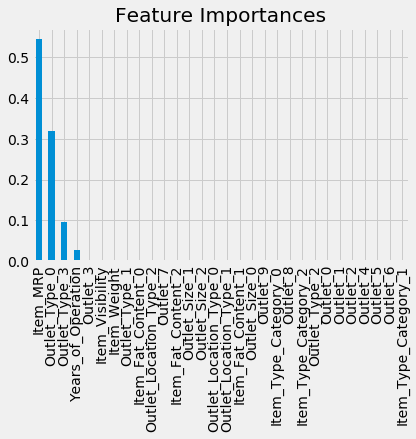

In [532]:
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg3 = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
modelfit(alg3, train, test, predictors, target, IDcol, 'alg3.csv')
coef3 = pd.Series(alg3.feature_importances_, predictors).sort_values(ascending=False)
coef3.plot(kind='bar', title='Feature Importances')

## Ridge Regression


Model Report
RMSE : 1129
CV Score : Mean - 0.7472 | Std - 0.01818 | Min - 0.7033 | Max - 0.7826


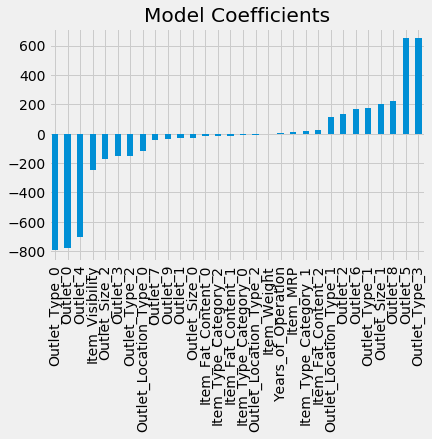

In [533]:
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg2 = Ridge(alpha=0.05,normalize=True)
modelfit(alg2, train, test, predictors, target, IDcol, 'alg2.csv')
coef2 = pd.Series(alg2.coef_, predictors).sort_values()
coef2.plot(kind='bar', title='Model Coefficients')

## From the above models, the Decision Tree model gives us the least RMSE score of 1060. Hence, it is the best fit model for my project.